In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Harris Corner Detector and SIFT Detector

### Harris Corner Detector

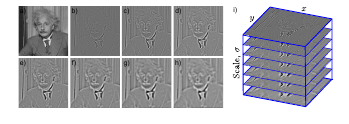
13. The SIFT detector. a) Original image. b-h) The image is ﬁltered with diﬀerence of Gaussian kernels at a range of increasing scales. i) The resulting images are stacked to create a 3D volume. Points that are local extrema in the ﬁltered image volume (i.e., are either greater than or less than all 26 3D neighbors) are considered to be candidates for interest points.

The Harris corner detector (see Fig.12) analyzes local gradients in both horizontal and vertical directions around each point in an image. Its primary objective is to identify points where the image intensity varies significantly in both directions (indicating a corner), as opposed to varying in only one direction (indicating an edge) or not varying at all (indicating a flat region).

The detector relies on the **image structure tensor**, defined as:

$$
S_{ij} = \sum_{m=i-D}^{i+D} \sum_{n=j-D}^{j+D} w_{mn}
\begin{bmatrix}
h_{mn}^2 & h_{mn} v_{mn} \\
h_{mn} v_{mn} & v_{mn}^2
\end{bmatrix}
$$

where:
- $ S_{ij} $ is the image structure tensor at position $ (i, j) $,
- The summation occurs over a square region of size $ (2D+1) \times (2D+1) $ centered at $ (i, j) $,
- $ h_{mn} $ represents the response of a horizontal derivative filter (e.g., Sobel) at position $ (m, n) $,
- $ v_{mn} $ represents the response of a vertical derivative filter at position $ (m, n) $,
- $ w_{mn} $ is a weighting factor that reduces the influence of points farther from the center $ (i, j) $.

To determine if a point is a corner, the Harris detector evaluates the singular values $ \lambda_1 $ and $ \lambda_2 $ of $ S_{ij} $:
- If both $ \lambda_1 $ and $ \lambda_2 $ are small, the region is smooth (not a corner).
- If one singular value is large and the other is small, the point lies on an edge.
- If both $ \lambda_1 $ and $ \lambda_2 $ are large, the point is a corner.

Instead of directly computing the singular values, the Harris detector uses an efficient criterion:

$$
c_{ij} = \lambda_1 \lambda_2 - \kappa (\lambda_1^2 + \lambda_2^2) = \det[S_{ij}] - \kappa \cdot \text{trace}[S_{ij}]
$$

where:
- $ \kappa $ is a constant (typically between 0.04 and 0.15),
- $ \det[S_{ij}] = \lambda_1 \lambda_2 $,
- $ \text{trace}[S_{ij}] = \lambda_1 + \lambda_2 $.

If $ c_{ij} $ exceeds a predefined threshold, the point is considered a corner candidate. A non-maximal suppression step, similar to that in the Canny edge detector, is applied to retain only the peaks in $ c_{ij} $.

##  SIFT Detector

The **Scale-Invariant Feature Transform (SIFT)** detector identifies interest points and assigns each a scale and orientation, making it more robust than the Harris corner detector for certain applications.

### SIFT Process
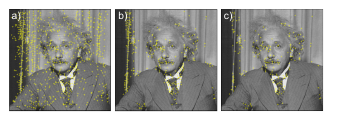

14. Reﬁnement of SIFT detector candidates. a) Positions of extrema in the ﬁltered image volume (ﬁgure 13.13i). Note that the scale is not shown. These are considered candidates to be interest points. b) Re- maining candidates after eliminating those in smooth regions. c) Remaining candidate points after removing those on edges using the image structure tensor.


1. The intensity image is filtered with a **Difference of Gaussian (DoG)** kernel at $ K $ increasingly coarse scales (see Fig.13).
2. The filtered images are stacked into a 3D volume of size $ I \times J \times K $, where $ I $ and $ J $ are the image dimensions.
3. Local extrema are identified in this volume by comparing each voxel to its 26 neighbors in a $ 3 \times 3 \times 3 $ block. A point is an extremum if it is greater than or less than all 26 neighbors.

### Refinement of Candidates
- Extrema are localized to sub-voxel accuracy using a quadratic approximation from a Taylor expansion around each point, providing sub-pixel resolution and a refined scale estimate.
- The image structure tensor $ S_{ij} $ (from Equation.14) is computed at each extremum’s location and scale.
- Candidates in smooth regions or on edges are discarded by analyzing the singular values of $ S_{ij} $, as in the Harris detector (see Fig.14).

### Orientation Assignment
For each remaining interest point:
- Local gradient amplitude and orientation are computed in a region proportional to the identified scale.
- An orientation histogram with 36 bins (covering 360°) is constructed, weighted by gradient amplitude and a Gaussian profile centered at the interest point.
- The peak of the histogram defines the point’s orientation. If a second peak exceeds 80% of the maximum, two orientations may be assigned (see Figure 13.15).

### Final Output
The SIFT detector produces interest points with:
- Sub-pixel accuracy in position,
- An associated scale,
- One or more orientations.

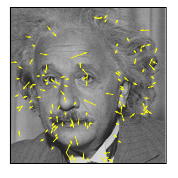

15. Results of SIFT detector. Each ﬁnal interest point is in- dicated using an arrow. The length of the arrow indicates the scale with which the interest point is identiﬁed and the angle of the arrow indicates the associated orientation. Notice that there are some positions in the image where the orientation was not unique and here two interest points are used, one associated with each ori- entation. An example of this is on the right shirt collar. Subsequent descrip- tors that characterize the structure of the image around the interest points are computed relative to this scale and orientation and hence inherit some invariance to these factors.


These points are depicted with arrows, where the arrow length represents the scale and the angle represents the orientation (see Fig.15).

## Descriptors
Descriptors summarize image region content compactly. A simple approach is to compute histograms of responses (e.g., RGB intensities, filter responses, local binary patterns, or textons) over a region. These histograms can be modeled as discrete categorical distributions or continuous vectors, depending on the application.

In [1]:
#!/usr/bin/env python3

"""
Implementation of Harris Corner Detector and SIFT Detector in a single file.
Requires: OpenCV, NumPy, Matplotlib.
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to display images
def display_image(img, title="Image", cmap=None):
    plt.figure(figsize=(8, 6))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Harris Corner Detector implementation
def harris_corner_detector(img):
    """
    Detect corners using the Harris Corner Detector.
    Parameters align with cv2.cornerHarris: blockSize, ksize, k.
    """
    # Convert image to float32 as required by cv2.cornerHarris
    img_float = np.float32(img)
    
    # Apply Harris Corner Detection
    block_size = 2    # Neighborhood size (2D+1 = 5 if D=2)
    ksize = 3         # Sobel filter size
    k = 0.04          # Harris constant (kappa)
    harris_response = cv2.cornerHarris(img_float, block_size, ksize, k)
    
    # Dilate to mark corners more prominently
    harris_response = cv2.dilate(harris_response, None)
    
    # Threshold to mark corners (adjust threshold as needed)
    threshold = 0.01 * harris_response.max()
    img_corners = img.copy()
    img_corners[harris_response > threshold] = 255  # Mark corners in white
    
    return img_corners, harris_response

# SIFT Detector implementation
def sift_detector(img):
    """
    Detect keypoints using the SIFT Detector, including scale and orientation.
    Returns image with keypoints drawn, keypoints list, and descriptors.
    """
    # Create SIFT object
    sift = cv2.SIFT_create()
    
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    # Draw keypoints on the image
    img_keypoints = cv2.drawKeypoints(
        img, 
        keypoints, 
        None, 
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS  # Show scale and orientation
    )
    
    return img_keypoints, keypoints, descriptors

# Main execution
def main():
    # Load a sample image (replace 'image.jpg' with your image path)
    image_path = 'image.jpg'  # Example: a grayscale-compatible image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if image loaded successfully
    if img is None:
        print("Error: Could not load image. Provide a valid image path.")
        return

    # Display original image
    print("Displaying original image...")
    display_image(img, "Original Image", cmap='gray')

    # Harris Corner Detector
    print("Running Harris Corner Detector...")
    corners, response = harris_corner_detector(img)
    display_image(corners, "Harris Corners", cmap='gray')
    display_image(response, "Harris Response", cmap='jet')  # Color map for response intensity

    # SIFT Detector
    print("Running SIFT Detector...")
    sift_img, keypoints, descriptors = sift_detector(img)
    display_image(sift_img, "SIFT Keypoints", cmap='gray')
    
    # Print some keypoint details
    print(f"Number of keypoints detected: {len(keypoints)}")
    print("First 5 keypoints:")
    for i, kp in enumerate(keypoints[:5]):
        print(f"Keypoint {i}: Position={kp.pt}, Scale={kp.size}, Orientation={kp.angle}")

    # Keep plots open until user closes them
    plt.show()

if __name__ == "__main__":
    main()

Error: Could not load image. Provide a valid image path.


[ WARN:0@11.833] global loadsave.cpp:248 findDecoder imread_('image.jpg'): can't open/read file: check file path/integrity


# SIFT and HOG Descriptors

## 1. Introduction

Feature descriptors are a way to represent regions of interest in images. They are designed to be:
- Distinctive (different image regions should have different descriptors)
- Invariant to various transformations (rotation, scale, illumination changes)
- Robust to small deformations and noise

This notebook explores two important descriptors:
1. Scale Invariant Feature Transform (SIFT)
2. Histogram of Oriented Gradients (HOG)

## 2. SIFT Descriptor

### 2.1 Overview

The SIFT descriptor characterizes the image region around an interest point. It is usually used in conjunction with interest points found using the SIFT detector. The goal is to create a representation that is partially invariant to:
- Intensity changes
- Contrast changes 
- Small geometric deformations

### 2.2 Computation Process

The SIFT descriptor is computed as follows:

1. Compute gradient orientation and amplitude maps in a 16×16 pixel region around the interest point using:

   $$\nabla I(x,y) = \begin{bmatrix} I(x+1,y) - I(x-1,y) \\ I(x,y+1) - I(x,y-1) \end{bmatrix}$$

   The gradient magnitude is:
   
   $$|\nabla I(x,y)| = \sqrt{(I(x+1,y) - I(x-1,y))^2 + (I(x,y+1) - I(x,y-1))^2}$$
   
   And the gradient orientation is:
   
   $$\theta(x,y) = \tan^{-1}\left(\frac{I(x,y+1) - I(x,y-1)}{I(x+1,y) - I(x-1,y)}\right)$$

2. Quantize the orientation into 8 bins spread over the range 0-360°

3. Divide the 16×16 region into a regular grid of non-overlapping 4×4 cells

4. Within each cell, compute an 8-dimensional histogram of gradient orientations
   - Each contribution is weighted by the gradient amplitude
   - Contributions are also weighted by distance from the interest point (pixels further away contribute less)

5. Concatenate the 16 histograms (from the 4×4 cells) to create a 128-dimensional vector (16 cells × 8 orientation bins)

6. Normalize the vector for invariance to contrast changes

### 2.3 Properties

- **Invariance to intensity**: Achieved by using gradients rather than raw pixel values
- **Invariance to contrast**: Achieved through final normalization
- **Robustness to small deformations**: Achieved by pooling information within each cell
- **Spatial information**: Preserved by keeping information from each cell separate

## 3. HOG Descriptor

### 3.1 Overview

The Histogram of Oriented Gradients (HOG) descriptor constructs a detailed characterization of spatial structure within a small image window. It's particularly useful for detecting objects with quasi-regular structure, such as pedestrians.

### 3.2 Computation Process (for pedestrian detection)

1. Compute gradient orientation and amplitude at every pixel in a 64×128 window using the same equations as for SIFT

2. Quantize the orientation into 9 bins spread over the range 0-180° (note: this is different from SIFT's 0-360° range, creating invariance to contrast polarity)

3. Divide the 64×128 region into a regular grid of 6×6 pixel cells

4. Compute a 9-dimensional orientation histogram within each cell
   - Contributions are weighted by gradient amplitude
   - Contributions are weighted by distance from center of cell

5. For each 3×3 block of cells:
   - Concatenate the histograms
   - Normalize to form a block descriptor

6. Concatenate all block descriptors to form the final HOG descriptor

### 3.3 Properties

- **Invariance to contrast polarity**: Achieved by using only 0-180° range for orientations
- **Higher spatial resolution**: Compared to SIFT, uses more cells with finer granularity
- **Local normalization**: Performed at the block level rather than globally
- **Invariance to local contrast**: Achieved through block normalization
- **Spatial structure preservation**: Maintained through the grid of cells

## 4. Comparison Between SIFT and HOG

| Property | SIFT | HOG |
|----------|------|-----|
| Orientation range | 0-360° | 0-180° |
| Invariance to contrast polarity | No | Yes |
| Spatial resolution | Lower (4×4 grid) | Higher (many 6×6 cells) |
| Normalization | Global | Local (per block) |
| Typical application | Object matching, recognition | Object detection (especially pedestrians) |
| Descriptor size | 128 dimensions | Varies based on window size |

## 5. Implementation Example

```python
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Load an image
img = cv2.imread('sample.jpg', 0)  # grayscale

# SIFT implementation
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(img, None)

# Visualize keypoints
img_kp = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(10, 8))
plt.imshow(img_kp)
plt.title('SIFT Keypoints')
plt.show()

# HOG implementation (for visualization)
def get_hog_visualization(img, cell_size=(8, 8), block_size=(2, 2), nbins=9):
    # Compute HOG
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                      img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                       block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)
    
    h = hog.compute(img)
    
    # Visualization code would go here
    # This is simplified - actual visualization would require more complex code
    
    return h

hog_features = get_hog_visualization(img)
print(f"HOG descriptor shape: {hog_features.shape}")
```

## 6. Mathematical Formulation

The key mathematical components of both descriptors are:

1. **Gradient calculation**: For an image $I(x,y)$, the gradient is:

   $$\nabla I(x,y) = \begin{bmatrix} \frac{\partial I}{\partial x} \\ \frac{\partial I}{\partial y} \end{bmatrix}$$

2. **Gradient magnitude**:

   $$|\nabla I(x,y)| = \sqrt{\left(\frac{\partial I}{\partial x}\right)^2 + \left(\frac{\partial I}{\partial y}\right)^2}$$

3. **Gradient orientation**:

   $$\theta(x,y) = \tan^{-1}\left(\frac{\partial I/\partial y}{\partial I/\partial x}\right)$$

4. **Histogram construction**: For each cell, the histogram is constructed by:

   $$H(b) = \sum_{(x,y) \in \text{cell}} w(x,y) \cdot \delta(b - \lfloor \theta(x,y) / \Delta \theta \rfloor)$$

   Where:
   - $w(x,y)$ is the weight (typically gradient magnitude and spatial weight)
   - $\delta$ is the Kronecker delta function
   - $\Delta \theta$ is the bin width
   - $b$ is the bin index

5. **Normalization**: For a feature vector $v$, the L2-norm normalization is:

   $$v_{\text{norm}} = \frac{v}{\sqrt{\|v\|_2^2 + \epsilon}}$$

   Where $\epsilon$ is a small constant to prevent division by zero.

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

def visualize_sift(image_path):
    # Load image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    print(f"Number of keypoints detected: {len(keypoints)}")
    print(f"Shape of descriptor for first keypoint: {descriptors[0].shape}")
    
    # Draw keypoints
    img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, 
                                          flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Convert from BGR to RGB for matplotlib
    img_with_keypoints_rgb = cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB)
    
    # Visualize a single descriptor
    if len(keypoints) > 0:
        # Get the first keypoint
        kp = keypoints[0]
        descriptor = descriptors[0]
        
        # Reshape the descriptor to visualize it as an 4x4 array of 8-element histograms
        descriptor_vis = descriptor.reshape(4, 4, 8)
        
        # Create a plot to visualize the keypoint and its descriptor
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot the image with keypoints
        ax1.imshow(img_with_keypoints_rgb)
        ax1.set_title('SIFT Keypoints')
        ax1.axis('off')
        
        # Create a visualization of the SIFT descriptor
        # This is a simplified visualization showing the magnitude of each bin
        ax2.matshow(np.sum(descriptor_vis, axis=2), cmap='viridis')
        ax2.set_title('SIFT Descriptor (First Keypoint)')
        ax2.set_xlabel('4x4 spatial grid')
        ax2.set_xticks(np.arange(4))
        ax2.set_yticks(np.arange(4))
        
        plt.tight_layout()
        plt.show()
        
        # Plot the 8-bin histogram for one cell
        plt.figure(figsize=(8, 4))
        plt.bar(range(8), descriptor_vis[1, 1, :])
        plt.title('Orientation Histogram for One Cell (1,1)')
        plt.xlabel('Orientation Bin')
        plt.ylabel('Weighted Magnitude')
        plt.show()
    
    return img_with_keypoints_rgb, keypoints, descriptors

def visualize_hog(image_path, cell_size=(8, 8), block_size=(2, 2), orientations=9):
    # Load image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale for HOG
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Resize to typical pedestrian detection size
    resized = cv2.resize(gray, (64, 128))
    
    # Calculate HOG features using scikit-image
    fd, hog_image = hog(
        resized, 
        orientations=orientations, 
        pixels_per_cell=cell_size,
        cells_per_block=block_size, 
        visualize=True, 
        feature_vector=True
    )
    
    print(f"HOG feature descriptor shape: {fd.shape}")
    
    # Enhance HOG visualization for better visibility
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    
    # Calculate gradients for visualization (approximating the process)
    gx = cv2.Sobel(resized, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(resized, cv2.CV_32F, 0, 1, ksize=1)
    
    # Gradient magnitude and orientation
    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = np.arctan2(gy, gx) * 180 / np.pi % 180
    
    # Create visualization
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original image
    axs[0, 0].imshow(img_rgb)
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')
    
    # Resized grayscale
    axs[0, 1].imshow(resized, cmap='gray')
    axs[0, 1].set_title('Resized (64 × 128)')
    axs[0, 1].axis('off')
    
    # Gradient magnitude
    axs[0, 2].imshow(magnitude, cmap='hot')
    axs[0, 2].set_title('Gradient Magnitude')
    axs[0, 2].axis('off')
    
    # Gradient orientation visualization (pseudo-color)
    orientation_rgb = np.zeros((*orientation.shape, 3), dtype=np.uint8)
    # Map angles to colors
    for i in range(orientation.shape[0]):
        for j in range(orientation.shape[1]):
            # Normalize angle to 0-1
            norm_angle = orientation[i, j] / 180.0
            # Simple HSV-like mapping (H=angle, S=1, V=magnitude)
            if magnitude[i, j] > 20:  # Only show strong gradients
                h = norm_angle
                s = 1.0
                v = min(1.0, magnitude[i, j] / 100.0)
                # Convert HSV to RGB (simplified)
                if h < 1/6:
                    r, g, b = 1, 6*h, 0
                elif h < 2/6:
                    r, g, b = 2-6*h, 1, 0
                elif h < 3/6:
                    r, g, b = 0, 1, 6*h-2
                elif h < 4/6:
                    r, g, b = 0, 4-6*h, 1
                elif h < 5/6:
                    r, g, b = 6*h-4, 0, 1
                else:
                    r, g, b = 1, 0, 6-6*h
                orientation_rgb[i, j] = [int(255*r*v), int(255*g*v), int(255*b*v)]
    
    axs[1, 0].imshow(orientation_rgb)
    axs[1, 0].set_title('Gradient Orientation')
    axs[1, 0].axis('off')
    
    # HOG visualization
    axs[1, 1].imshow(hog_image_rescaled, cmap='gray')
    axs[1, 1].set_title('HOG Feature Visualization')
    axs[1, 1].axis('off')
    
    # Feature vector visualization (simplified)
    # Reshape HOG features to match blocks
    blocks_shape = (
        (resized.shape[0] // cell_size[0]) - block_size[0] + 1,
        (resized.shape[1] // cell_size[1]) - block_size[1] + 1,
        block_size[0], block_size[1], orientations
    )
    
    # Create a visualization of HOG blocks average value
    n_blocks_y, n_blocks_x = blocks_shape[0], blocks_shape[1]
    hog_blocks_avg = np.zeros((n_blocks_y, n_blocks_x))
    
    # Calculate average magnitude in each block from the feature vector
    feature_idx = 0
    for y in range(n_blocks_y):
        for x in range(n_blocks_x):
            block_features = fd[feature_idx:feature_idx + block_size[0] * block_size[1] * orientations]
            hog_blocks_avg[y, x] = np.mean(block_features)
            feature_idx += block_size[0] * block_size[1] * orientations
    
    axs[1, 2].matshow(hog_blocks_avg, cmap='viridis')
    axs[1, 2].set_title('HOG Block Average Energy')
    axs[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return fd, hog_image_rescaled

def compare_descriptors(image1_path, image2_path):
    """Compare SIFT descriptors between two images"""
    # Load images
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
    
    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    
    # Detect and compute keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    
    # Create BFMatcher (Brute Force Matcher)
    bf = cv2.BFMatcher()
    
    # Match descriptors
    matches = bf.knnMatch(des1, des2, k=2)
    
    # Apply ratio test to get good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append([m])
    
    # Draw matches
    img_matches = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
    
    # Convert to RGB for matplotlib
    img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
    
    # Visualize matches
    plt.figure(figsize=(15, 8))
    plt.imshow(img_matches_rgb)
    plt.title(f'SIFT Matches: {len(good_matches)} good matches out of {len(matches)} total')
    plt.axis('off')
    plt.show()
    
    return img_matches_rgb, good_matches

# Example usage (uncomment to run)
# Replace with actual image paths
# img_path = 'sample_image.jpg'
# img_path2 = 'sample_image_rotated.jpg'

# # Visualize SIFT features
# sift_img, keypoints, descriptors = visualize_sift(img_path)

# # Visualize HOG features
# hog_features, hog_image = visualize_hog(img_path)

# # Compare two images using SIFT
# matches_img, good_matches = compare_descriptors(img_path, img_path2)

# Function to implement our own simple SIFT-like descriptor (for educational purposes)
def simple_sift_descriptor(img, keypoint, patch_size=16, cell_size=4, num_bins=8):
    """
    Create a simplified SIFT-like descriptor for a keypoint
    
    Parameters:
    - img: grayscale image
    - keypoint: (x, y) tuple for keypoint position
    - patch_size: size of patch around keypoint (default 16x16)
    - cell_size: size of cell for histogram (default 4x4)
    - num_bins: number of orientation bins (default 8)
    
    Returns:
    - descriptor: feature vector
    """
    x, y = keypoint
    half_size = patch_size // 2
    
    # Extract patch around keypoint
    patch = img[max(0, y-half_size):min(img.shape[0], y+half_size), 
                max(0, x-half_size):min(img.shape[1], x+half_size)]
    
    # Resize patch to ensure it's exactly patch_size x patch_size
    if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
        patch = cv2.resize(patch, (patch_size, patch_size))
    
    # Compute gradients
    gx = cv2.Sobel(patch, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(patch, cv2.CV_32F, 0, 1, ksize=1)
    
    # Gradient magnitude and orientation
    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = np.arctan2(gy, gx) * 180 / np.pi % 360
    
    # Create Gaussian weight array for the patch
    sigma = patch_size / 2
    y_grid, x_grid = np.mgrid[0:patch_size, 0:patch_size]
    center_y, center_x = patch_size / 2, patch_size / 2
    gaussian_weight = np.exp(-((x_grid - center_x)**2 + (y_grid - center_y)**2) / (2 * sigma**2))
    
    # Apply weights to magnitude
    weighted_magnitude = magnitude * gaussian_weight
    
    # Initialize descriptor
    num_cells = patch_size // cell_size
    descriptor = np.zeros((num_cells, num_cells, num_bins))
    
    # Compute histograms for each cell
    for i in range(num_cells):
        for j in range(num_cells):
            # Cell boundaries
            y_start, y_end = i * cell_size, (i + 1) * cell_size
            x_start, x_end = j * cell_size, (j + 1) * cell_size
            
            # Extract cell
            cell_orientation = orientation[y_start:y_end, x_start:x_end]
            cell_magnitude = weighted_magnitude[y_start:y_end, x_start:x_end]
            
            # Compute histogram
            for m in range(cell_size):
                for n in range(cell_size):
                    bin_idx = int(cell_orientation[m, n] * num_bins / 360) % num_bins
                    descriptor[i, j, bin_idx] += cell_magnitude[m, n]
    
    # Flatten and normalize descriptor
    descriptor = descriptor.flatten()
    norm = np.sqrt(np.sum(descriptor**2))
    if norm > 1e-6:
        descriptor /= norm
    
    return descriptor

# Function to implement a simple HOG-like descriptor
def simple_hog_descriptor(img, cell_size=6, block_size=3, num_bins=9):
    """
    Create a simplified HOG descriptor for an image
    
    Parameters:
    - img: grayscale image
    - cell_size: size of cell for histogram (default 6x6)
    - block_size: size of block (in cells) for normalization (default 3x3)
    - num_bins: number of orientation bins (default 9)
    
    Returns:
    - descriptor: HOG feature vector
    """
    # Compute gradients
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
    
    # Gradient magnitude and orientation (0-180 degrees)
    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = np.arctan2(gy, gx) * 180 / np.pi % 180
    
    # Dimensions
    height, width = img.shape
    cells_y = height // cell_size
    cells_x = width // cell_size
    
    # Initialize cell histograms
    cell_histograms = np.zeros((cells_y, cells_x, num_bins))
    
    # Compute histograms for each cell
    for y in range(cells_y):
        for x in range(cells_x):
            # Cell boundaries
            y_start, y_end = y * cell_size, (y + 1) * cell_size
            x_start, x_end = x * cell_size, (x + 1) * cell_size
            
            # Cell center for distance weighting
            cell_center_y = y_start + cell_size / 2
            cell_center_x = x_start + cell_size / 2
            
            # Extract cell
            cell_orientation = orientation[y_start:y_end, x_start:x_end]
            cell_magnitude = magnitude[y_start:y_end, x_start:x_end]
            
            # Compute histogram with distance weighting
            for i in range(cell_size):
                for j in range(cell_size):
                    pixel_y, pixel_x = y_start + i, x_start + j
                    
                    # Distance weight
                    dist = np.sqrt((pixel_y - cell_center_y)**2 + (pixel_x - cell_center_x)**2)
                    weight = np.exp(-0.5 * (dist / (cell_size / 2))**2)
                    
                    # Orientation bin (0-180 degrees)
                    bin_idx = int(cell_orientation[i, j] * num_bins / 180) % num_bins
                    
                    # Add weighted magnitude to histogram
                    cell_histograms[y, x, bin_idx] += cell_magnitude[i, j] * weight
    
    # Initialize block normalized descriptor
    blocks_y = cells_y - block_size + 1
    blocks_x = cells_x - block_size + 1
    
    # If no complete blocks can be formed, return empty descriptor
    if blocks_y <= 0 or blocks_x <= 0:
        return np.array([])
    
    # Size of descriptor: (blocks_y * blocks_x) blocks, each with (block_size * block_size * num_bins) features
    descriptor = np.zeros((blocks_y * blocks_x * block_size * block_size * num_bins))
    
    # Normalize by blocks
    block_idx = 0
    for y in range(blocks_y):
        for x in range(blocks_x):
            # Block boundaries (in cells)
            block_hist = cell_histograms[y:y+block_size, x:x+block_size, :].flatten()
            
            # L2 normalization with epsilon to avoid division by zero
            norm = np.sqrt(np.sum(block_hist**2) + 1e-6)
            if norm > 0:
                block_hist /= norm
            
            # Add to descriptor
            start_idx = block_idx * (block_size * block_size * num_bins)
            end_idx = start_idx + (block_size * block_size * num_bins)
            descriptor[start_idx:end_idx] = block_hist
            block_idx += 1
    
    return descriptor

## Advanced Image Descriptors and Dimensionality Reduction

###  Bag of Words Descriptor

The Bag of Words (BoW) model is a technique originally developed for text analysis but adapted for computer vision. Unlike SIFT and HOG which characterize small image regions, BoW aims to represent larger regions or entire images.

###  Concept

The Bag of Words descriptor represents an image as a histogram of visual words, disregarding their spatial arrangement:

1. **Visual Dictionary Creation**:
   - Extract interest points from many training images
   - Compute descriptors (e.g., SIFT) for each interest point
   - Cluster these descriptors using K-means to create a "visual vocabulary"
   - Each cluster center becomes a "visual word"

2. **Image Representation**:
   - Extract interest points from a new image
   - Compute descriptors for each interest point
   - Assign each descriptor to the nearest visual word
   - Create a histogram counting the frequency of each visual word

###  Mathematical Formulation

For an image with $n$ interest points and a dictionary of $K$ visual words:

1. Extract descriptors $\{d_1, d_2, ..., d_n\}$ from the image

2. For each descriptor $d_i$, find the closest visual word $w_j$ using:
   $$j = \underset{j \in \{1,2,...,K\}}{\arg\min} \|d_i - w_j\|^2$$

3. The BoW histogram $h$ is then:
   $$h = [h_1, h_2, ..., h_K]$$
   where $h_j$ is the number of descriptors assigned to visual word $w_j$

4. The histogram is often normalized:
   $$h_{norm} = \frac{h}{\|h\|_1} = \frac{h}{\sum_{j=1}^K h_j}$$

###  Properties

- **Advantages**:
  - Remarkably effective for object recognition despite ignoring spatial information
  - Provides a fixed-length representation regardless of image size or number of interest points
  - Robust to occlusion and viewpoint changes

- **Limitations**:
  - Loses all spatial information about feature arrangement
  - Difficult to localize objects after identification
  - Cannot determine how many instances of an object are present

## 2. Shape Context Descriptor

The Shape Context descriptor is designed to characterize object shape through silhouettes and contours, which is particularly useful when RGB values are less informative (e.g., human pose estimation).

### 2.1 Computation Process

1. Sample points along the object contour at equally spaced intervals

2. For each sampled point:
   - Center a log-polar coordinate system at the point
   - Count how many other contour points fall into each bin of this coordinate system
   - Create a histogram representing this distribution

3. The complete descriptor consists of the concatenated histograms from all sampled points

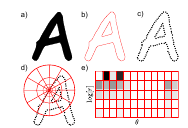

a) Object silhouette. b) Con- tour of silhouette. c) Points are placed at equally spaced intervals around the silhouette. d) A log polar sampling array is centered at each point. e) The shape of the object relative to this point is captured by the histogram over the bins of the log polar array. The ﬁnal descriptor would consist of a concatenation of the values from his- tograms from multiple points around the edge of the object.
### Mathematical Formulation

1. For a point $p_i$ on the contour, the shape context is defined as:
   $$h_i(k) = \#\{q \neq p_i : (q - p_i) \in \text{bin}(k)\}$$

   where $q$ represents other points on the contour, and $\text{bin}(k)$ is the $k$-th bin in the log-polar coordinate system.

2. The log-polar binning has:
   - $r$ bins for logarithmically-spaced distance intervals
   - $\theta$ bins for evenly-spaced angle intervals
   
   Creating a total of $r \times \theta$ bins

3. The complete shape context descriptor for a shape with $n$ points is:
   $$SC = [h_1, h_2, ..., h_n]$$
   where each $h_i$ is the histogram for point $p_i$

###  Properties

- **Log-polar binning**: Provides more sensitivity to nearby points than distant ones
- **Rotation invariance**: Can be achieved by aligning the coordinate system with the local contour orientation
- **Shape matching**: Requires establishing point correspondence between shapes

## Dimensionality Reduction

Dimensionality reduction techniques aim to find lower-dimensional representations of data that preserve important variations while eliminating redundancy.

###  Motivation

- High-dimensional image data typically lies on a lower-dimensional manifold
- Reducing dimensions can lead to models with fewer parameters
- Faster learning and inference
- Potentially better generalization

###  Mathematical Formulation

The goal is to find a low-dimensional representation $h$ that can approximately explain the original data $x$:

$$x \approx f[h, \theta]$$

where $f[\cdot, \cdot]$ is a function with parameters $\theta$ that maps from the hidden representation to the original data space.

To find optimal parameters, we minimize the reconstruction error:

$$\hat{\theta}, \hat{h}_1, \ldots, \hat{h}_I = \arg\min_{\theta, h_1, \ldots, h_I} \sum_{i=1}^I (x_i - f[h_i, \theta])^T (x_i - f[h_i, \theta])$$

where $x_i$ is the $i$-th of $I$ training examples.

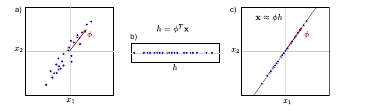
19, Reduction to a single dimension. a) Original data and direction φ of maximum variance. b) The data are projected onto φ to produce a one dimensional representation. c) To reconstruct the data, we re-multiply by φ. Most of the original variation is retained. PCA extends this model to project high dimensional data onto the K orthogonal dimensions with the most variance, to produce a K dimensional representation.

### Principal Component Analysis (PCA)

PCA is one of the most common dimensionality reduction techniques:

1. **Basic concept**: Project high-dimensional data onto the $K$ orthogonal directions with the highest variance

2. **For centered data $X$ (with mean subtracted):**
   - Compute the covariance matrix $C = \frac{1}{n}X^TX$
   - Find the eigenvectors and eigenvalues of $C$
   - Sort eigenvectors by decreasing eigenvalues
   - Select the top $K$ eigenvectors as the projection directions

3. **Projection**: If $\Phi$ is a matrix with the top $K$ eigenvectors as columns, then:
   - Low-dimensional representation: $h = \Phi^T x$
   - Reconstruction: $\hat{x} = \Phi h = \Phi \Phi^T x$

4. **Reconstruction error** is minimized among all linear projections to $K$ dimensions

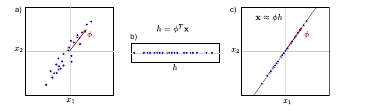

18. Shape context descriptor. a) Object silhouette. b) Con- tour of silhouette. c) Points are placed at equally spaced intervals around the silhouette. d) A log polar sampling array is centered at each point. e) The shape of the object relative to this point is captured by the histogram over the bins of the log polar array. The ﬁnal descriptor would consist of a concatenation of the values from his- tograms from multiple points around the edge of the object.


## 4. Implementation Examples

### 4.1 Bag of Words Implementation


## 5. Mathematical Details of PCA

Principal Component Analysis (PCA) is a linear dimensionality reduction technique that finds the directions of maximum variance in high-dimensional data.

### 5.1 Computing Principal Components

For a matrix $X \in \mathbb{R}^{n \times d}$ with $n$ samples in $d$ dimensions:

1. Center the data by subtracting the mean:
   $$X_{centered} = X - \bar{X}$$
   where $\bar{X}$ is the mean of each dimension.

2. Compute the covariance matrix:
   $$C = \frac{1}{n} X_{centered}^T X_{centered}$$

3. Find the eigenvectors and eigenvalues of $C$:
   $$C v_i = \lambda_i v_i$$
   where $v_i$ is the $i$-th eigenvector and $\lambda_i$ is the corresponding eigenvalue.

4. Sort eigenvectors by decreasing eigenvalues.

5. Choose the first $k$ eigenvectors to form the projection matrix:
   $$P = [v_1, v_2, \ldots, v_k]$$

6. Project the data onto the new subspace:
   $$Z = X_{centered} P$$

### 5.2 Reconstruction

The original data can be approximated by:

$$\hat{X} = Z P^T + \bar{X}$$

### 5.3 Explained Variance

The proportion of variance explained by the $i$-th principal component is:

$$\frac{\lambda_i}{\sum_{j=1}^{d} \lambda_j}$$

The total variance explained by the first $k$ components is:

$$\frac{\sum_{i=1}^{k} \lambda_i}{\sum_{j=1}^{d} \lambda_j}$$

## 6. Comparison of Descriptors

| Descriptor | Scope | Spatial Information | Use Cases | Invariance |
|------------|-------|---------------------|-----------|------------|
| SIFT | Local region | Preserved | Object recognition, matching | Scale, rotation, illumination |
| HOG | Local region | Preserved | Object detection, pedestrians | Illumination, small deformations |
| Bag of Words | Entire image | Lost | Image classification, retrieval | Viewpoint, occlusion |
| Shape Context | Object contour | Partially preserved | Shape matching, pose estimation | Scale (with normalization) |

Each descriptor offers different trade-offs between preserving spatial information and achieving invariance to various transformations.

## 7. Recent Advances

While traditional descriptors like SIFT, HOG, Bag of Words, and Shape Context were state-of-the-art for many years, modern computer vision systems often use:

1. **Learned Features**: Convolutional Neural Networks (CNNs) learn feature representations from data
2. **Deep Embeddings**: Networks trained to map images to compact feature vectors
3. **Attention Mechanisms**: Models that focus on relevant parts of the image
4. **Transformers**: Architecture that processes the image as a sequence of patches

These approaches often outperform traditional hand-crafted descriptors for many tasks, but the classical methods continue to be valuable in specific domains and when training data is limited.

In [ ]:

import numpy as np
import cv2
from sklearn.cluster import KMeans

def create_visual_dictionary(images, num_words=1000):
    """Create a visual dictionary from a set of images"""
    # Extract SIFT features from all images
    sift = cv2.SIFT_create()
    all_descriptors = []
    
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        if descriptors is not None:
            all_descriptors.append(descriptors)
    
    # Stack all descriptors
    all_descriptors = np.vstack(all_descriptors)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_words, random_state=0)
    kmeans.fit(all_descriptors)
    
    return kmeans.cluster_centers_

def compute_bow_descriptor(image, visual_dictionary):
    """Compute Bag of Words descriptor for an image"""
    # Extract SIFT features
    sift = cv2.SIFT_create()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    # Initialize histogram
    histogram = np.zeros(len(visual_dictionary))
    
    if descriptors is not None:
        # Find closest visual word for each descriptor
        for descriptor in descriptors:
            distances = np.linalg.norm(visual_dictionary - descriptor, axis=1)
            closest_word = np.argmin(distances)
            histogram[closest_word] += 1
        
        # Normalize histogram
        if np.sum(histogram) > 0:
            histogram = histogram / np.sum(histogram)
    
    return histogram

### Shape Context Implementation


import numpy as np
import cv2
import matplotlib.pyplot as plt

def compute_shape_context(contour, num_points=100, num_distance_bins=5, num_angle_bins=12):
    """Compute shape context descriptor for a contour"""
    # Resample contour to have equal spacing
    contour = np.squeeze(contour)  # Remove singleton dimensions
    if len(contour.shape) != 2:
        return None
    
    # Sample points evenly along contour
    perimeter = cv2.arcLength(contour.astype(np.float32), True)
    step = perimeter / num_points
    sampled_points = []
    dist_traveled = 0
    
    for i in range(len(contour) - 1):
        p1 = contour[i]
        p2 = contour[i + 1]
        d = np.linalg.norm(p2 - p1)
        
        while dist_traveled + d >= step:
            alpha = (step - dist_traveled) / d
            point = p1 + alpha * (p2 - p1)
            sampled_points.append(point)
            dist_traveled = 0
            d = d - alpha * d
            p1 = point
        
        dist_traveled += d
    
    # If we didn't get enough points, use original points
    if len(sampled_points) < num_points:
        indices = np.linspace(0, len(contour) - 1, num_points).astype(int)
        sampled_points = contour[indices]
    else:
        sampled_points = np.array(sampled_points[:num_points])
    
    # Compute center of mass
    center = np.mean(sampled_points, axis=0)
    
    # Compute max distance for log-polar binning
    max_dist = np.max(np.linalg.norm(sampled_points - center, axis=1))
    
    # Create shape context descriptor for each point
    shape_contexts = []
    
    for i, point in enumerate(sampled_points):
        # Initialize histogram
        hist = np.zeros((num_distance_bins, num_angle_bins))
        
        # For each point, compute relation to all other points
        for j, other in enumerate(sampled_points):
            if i == j:
                continue
            
            # Compute distance and angle
            diff = other - point
            distance = np.linalg.norm(diff)
            angle = np.arctan2(diff[1], diff[0]) + np.pi  # Map to [0, 2π]
            
            # Log-space distance binning
            if distance > 0:
                log_dist = np.log(distance / (0.1 * max_dist))  # Avoid log(0)
                dist_bin = min(int(log_dist * num_distance_bins / np.log(10)), num_distance_bins - 1)
                dist_bin = max(0, dist_bin)  # Ensure non-negative
                
                # Angle binning
                angle_bin = int(angle / (2 * np.pi) * num_angle_bins) % num_angle_bins
                
                # Add to histogram
                hist[dist_bin, angle_bin] += 1
        
        # Normalize histogram
        if np.sum(hist) > 0:
            hist = hist / np.sum(hist)
        
        shape_contexts.append(hist.flatten())
    
    return np.array(shape_contexts)


###  PCA Implementation


import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def perform_pca(data, n_components=2):
    """Perform PCA and return transformed data and components"""
    # Center data
    mean = np.mean(data, axis=0)
    centered_data = data - mean
    
    # Use scikit-learn for PCA
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(centered_data)
    
    # Reconstruct
    reconstructed_data = pca.inverse_transform(transformed_data) + mean
    
    # Calculate reconstruction error
    reconstruction_error = np.mean(np.sum((data - reconstructed_data) ** 2, axis=1))
    
    print(f"Variance explained: {np.sum(pca.explained_variance_ratio_) * 100:.2f}%")
    print(f"Reconstruction error: {reconstruction_error:.6f}")
    
    return transformed_data, pca.components_, reconstructed_data, mean

# Example with visualization
def visualize_pca_on_images(images, height, width, n_components=10):
    """Visualize PCA on a set of images"""
    # Flatten images
    X = np.array([img.flatten() for img in images])
    
    # Perform PCA
    transformed, components, reconstructed, mean = perform_pca(X, n_components)
    
    # Plot mean and components
    plt.figure(figsize=(12, 8))
    
    # Mean image
    plt.subplot(3, 4, 1)
    plt.imshow(mean.reshape(height, width), cmap='gray')
    plt.title('Mean Image')
    plt.axis('off')
    
    # Principal components
    for i in range(min(n_components, 9)):
        plt.subplot(3, 4, i + 2)
        component = components[i].reshape(height, width)
        plt.imshow(component, cmap='gray')
        plt.title(f'PC {i+1}')
        plt.axis('off')
    
    # Original and reconstructed image examples
    plt.figure(figsize=(12, 6))
    for i in range(min(5, len(images))):
        # Original
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].reshape(height, width), cmap='gray')
        plt.title(f'Original {i+1}')
        plt.axis('off')
        
        # Reconstructed
        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructed[i].reshape(height, width), cmap='gray')
        plt.title(f'Reconstructed {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [1]:
#!/usr/bin/env python3

"""
Implementation of Harris Corner Detector and SIFT Detector in a single file.
Requires: OpenCV, NumPy, Matplotlib.
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to display images
def display_image(img, title="Image", cmap=None):
    plt.figure(figsize=(8, 6))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Harris Corner Detector implementation
def harris_corner_detector(img):
    """
    Detect corners using the Harris Corner Detector.
    Parameters align with cv2.cornerHarris: blockSize, ksize, k.
    """
    # Convert image to float32 as required by cv2.cornerHarris
    img_float = np.float32(img)
    
    # Apply Harris Corner Detection
    block_size = 2    # Neighborhood size (2D+1 = 5 if D=2)
    ksize = 3         # Sobel filter size
    k = 0.04          # Harris constant (kappa)
    harris_response = cv2.cornerHarris(img_float, block_size, ksize, k)
    
    # Dilate to mark corners more prominently
    harris_response = cv2.dilate(harris_response, None)
    
    # Threshold to mark corners (adjust threshold as needed)
    threshold = 0.01 * harris_response.max()
    img_corners = img.copy()
    img_corners[harris_response > threshold] = 255  # Mark corners in white
    
    return img_corners, harris_response

# SIFT Detector implementation
def sift_detector(img):
    """
    Detect keypoints using the SIFT Detector, including scale and orientation.
    Returns image with keypoints drawn, keypoints list, and descriptors.
    """
    # Create SIFT object
    sift = cv2.SIFT_create()
    
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(img, None)
    
    # Draw keypoints on the image
    img_keypoints = cv2.drawKeypoints(
        img, 
        keypoints, 
        None, 
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS  # Show scale and orientation
    )
    
    return img_keypoints, keypoints, descriptors

# Main execution
def main():
    # Load a sample image (replace 'image.jpg' with your image path)
    image_path = 'image.jpg'  # Example: a grayscale-compatible image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if image loaded successfully
    if img is None:
        print("Error: Could not load image. Provide a valid image path.")
        return

    # Display original image
    print("Displaying original image...")
    display_image(img, "Original Image", cmap='gray')

    # Harris Corner Detector
    print("Running Harris Corner Detector...")
    corners, response = harris_corner_detector(img)
    display_image(corners, "Harris Corners", cmap='gray')
    display_image(response, "Harris Response", cmap='jet')  # Color map for response intensity

    # SIFT Detector
    print("Running SIFT Detector...")
    sift_img, keypoints, descriptors = sift_detector(img)
    display_image(sift_img, "SIFT Keypoints", cmap='gray')
    
    # Print some keypoint details
    print(f"Number of keypoints detected: {len(keypoints)}")
    print("First 5 keypoints:")
    for i, kp in enumerate(keypoints[:5]):
        print(f"Keypoint {i}: Position={kp.pt}, Scale={kp.size}, Orientation={kp.angle}")

    # Keep plots open until user closes them
    plt.show()

if __name__ == "__main__":
    main()

Error: Could not load image. Provide a valid image path.


[ WARN:0@3.509] global loadsave.cpp:248 findDecoder imread_('image.jpg'): can't open/read file: check file path/integrity
